<a href="https://colab.research.google.com/github/ganjiron/ganpython/blob/master/SWAE_LSTM_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 변수의 shape, type, value 확인
def p(var) :
    if type(var)!=type([]):
        try: 
            print(f'Shape:{var.shape}')
        except : 
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

# LSTM AutoEncoder : WSAE-LSTM
ref : https://github.com/ivan-ivy/ECBM4040-final-project-WSAE-LSTM 

## Wavelet Transform coding 


### **Import Module**

In [ ]:
#!pip install PyWavelets

In [9]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt as pywt 
from statsmodels.robust import mad
tf.__version__

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.7.0'

In [ ]:
tf.__version__

'2.7.0'

In [57]:
pip --version

pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


### **DataSet Load**

https://github.com/FinanceData/FinanceDataReader

In [2]:
!pip install finance-datareader

In [3]:
#!pip install beautifulsoup4 

In [4]:
import FinanceDataReader as fdr

In [5]:
# Samsung(005930), 1992-01-01 ~ 2018-10-31
df = fdr.DataReader('005930', '2000-01-01')

In [6]:
df.head(),df.tail()

(            Open  High   Low  Close   Volume    Change
 Date                                                  
 2000-01-04  6000  6110  5660   6110  1483967  0.148496
 2000-01-05  5800  6060  5520   5580  1493604 -0.086743
 2000-01-06  5750  5780  5580   5620  1087810  0.007168
 2000-01-07  5560  5670  5360   5540   806195 -0.014235
 2000-01-10  5600  5770  5580   5770   937615  0.041516,
              Open   High    Low  Close    Volume    Change
 Date                                                      
 2021-12-29  80200  80200  78500  78800  19794795 -0.018680
 2021-12-30  78900  79500  78100  78300  14236700 -0.006345
 2022-01-03  79400  79800  78200  78600  13502112  0.003831
 2022-01-04  78800  79200  78300  78700  12427416  0.001272
 2022-01-05  78800  79000  76400  77400  25329387 -0.016518)

In [10]:
np_data = np.array(df) #np <- pandas data format 

In [14]:
np_data[:,0]

array([ 6000.,  5800.,  5750., ..., 79400., 78800., 78800.])

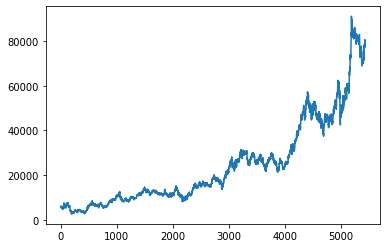

In [11]:
plt.plot(np_data[:,3]) 

In [15]:
# 최대,최소값으로 정규화 하기
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = (np.max(data, 0) - np.min(data, 0)) + 1e-7
    return numerator/denominator

In [16]:
len(np_data)

5435

In [17]:
## Normalize & input, output split 
if (len(np_data)%2) == 0 :  ## for even dataset
    np_data = np_data[1:,...]

xy = MinMaxScaler(np_data)# minmax 정규화
X = xy[0:-1]              # input data( Open,High.Low,Close,Volume,Change)
Y = xy[1: , 3]            # 다음날 종가 slicing -> target data

# data type 확인
ps(X,"X")
ps(Y,"Y")

[X] Shape(5434, 6)
[Y] Shape(5434,)


In [18]:
def plot_diff(x1,x2,s,e):
    in_data = x1[s:e]
    out_data = x2[s:e]
    plt.figure(figsize=(8,4))
    plt.plot( in_data, color="b", alpha=0.5, linewidth=2) 
    plt.plot( out_data, color="r")
    plt.grid('True')

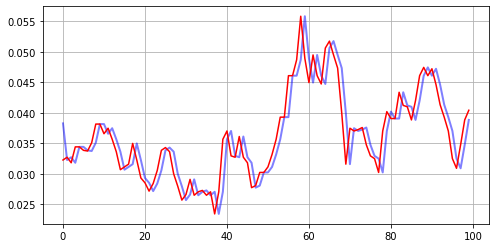

In [19]:
# 다음날 가격, 하루 앞서서 보임
s_p = 0
e_p = 100
plot_diff(X[:,3],Y,s_p,e_p) # Close

In [20]:
## Train, Test data split 
s_rate = 0.9  #train 90%

train_size = int(len(X) * s_rate)
if train_size%2 == 1 :     # for evne 
    train_size -= 1
test_size  = len(X) - train_size
x_train = np.array(X[0:train_size])
y_train = np.array(Y[0:train_size])
x_test  = np.array(X[train_size:len(X)])
y_test  = np.array(Y[train_size:len(Y)])

In [21]:
ps(x_train,'x_train')
ps(y_train,'y_train')
ps(x_test,'x_test')
ps(y_test,'y_test')

[x_train] Shape(4890, 6)
[y_train] Shape(4890,)
[x_test] Shape(544, 6)
[y_test] Shape(544,)


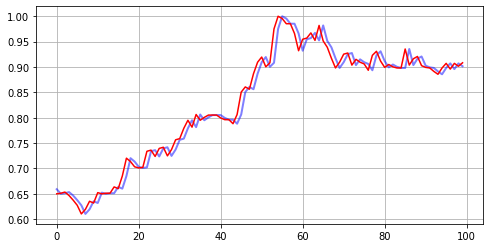

In [22]:
# split 결과 확인 
s_p = -300
e_p = -200
plot_diff(x_test[:,3],y_test,s_p,e_p) # Close

### Wavelet Transform

#### Decomposition, Reconstruction Test

**Coding : Decomposition** 

---
```python
# Multilevel decomposition methode
pywt.wavedec(data, wavelet, level=None, mode='symmetric', axis=-1)
```
---

In [23]:
#import pywt as pywt 
w = pywt.Wavelet('haar') # "dmey"
coeffs = pywt.wavedec(x_train, w, level=2, mode='per', axis=0) #'per':periodic padding

**Decoding : Reconstruction**

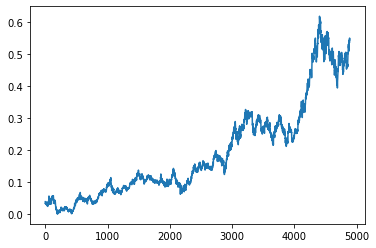

In [24]:
reconstructed_signal = pywt.waverec(coeffs, 'haar', mode='per', axis=0)
plt.plot(reconstructed_signal[:,3])

**Coefficient : Sn,Dn,Dn-1,...D1** 

In [25]:
w = pywt.Wavelet('haar')
coeffs2 = pywt.wavedec(x_train, w, level=2, mode='per', axis=0)
s2,d2,d1 = coeffs
ps(s2),ps(d2),ps(d1)

[] Shape(1223, 6)
[] Shape(1223, 6)
[] Shape(2445, 6)


(None, None, None)

#### Wavelet Layer processing

---
```python
# coefficients reduce by thresholding function
threshold : data/np.abs(data) * np.maximum(np.abs(data) - value, 0)
```
---

In [26]:
# http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
def waveletSmooth( x, wavelet="haar", level=2, declevel=2, sm=1):

    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per",level=declevel,axis=0 )

    # calculate a threshold
    sigma = mad(coeff[-level])
    if len(x.shape)==1 :
        print(f'Coeff d2 mean : {np.mean(coeff[1])}')
        print(f'Coeff d1 mean : {np.mean(coeff[2])}')
    uthresh = sigma * np.sqrt( 2*np.log(len(x))) * sm
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="hard" ) for i in coeff[1:] )
    if len(x.shape)==1 :
        print(f'Tresohold value : {float(uthresh):02f}')
        print(f'Coeff d2 mean : {np.mean(coeff[1])}')
        print(f'Coeff d1 mean : {np.mean(coeff[2])}')
    # reconstruct 
    y = pywt.waverec( coeff, wavelet, mode="per",axis=0 )
    return y

In [27]:
## coeff meam 값의 변화를 확인 
temp = waveletSmooth(y_train) # for Coeff. test 
#temp = waveletSmooth(y_train,sm=2) # smoothing factor 변화 

Coeff d2 mean : -0.00026149975994422034
Coeff d1 mean : -8.83309497318378e-05
Tresohold value : 0.016962
Coeff d2 mean : -4.103591698735023e-05
Coeff d1 mean : 1.4416030371664928e-05


```
sm = 2 인 경우 : d2,d1이 많이 줄어들어 '0'이 될 수 있음 
Coeff d2 mean : -0.00024918333345430864
Coeff d1 mean : -9.578574475368267e-05
Tresohold value : 0.033363
Coeff d2 mean : 2.7282846728573883e-05
Coeff d1 mean : 0.0
```

In [28]:
## x_train, x_test data noise제거 
w_x_train = waveletSmooth(x_train)
w_x_test = waveletSmooth(x_test)
len(x_train),len(w_x_train),len(x_test),len(w_x_test)

(4890, 4890, 544, 544)

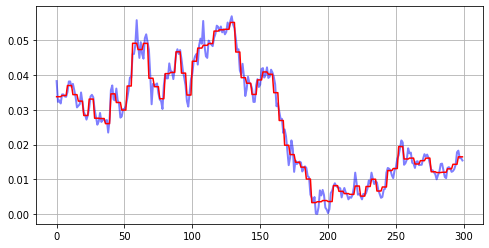

In [29]:
## noise reduction 확인 
s_p = 0
e_p = 300
plot_diff(x_train[:,3],w_x_train[:,3],s_p,e_p) # Train_Close
#plot_diff(x_test[:,3],w_x_test[:,3],s_p,e_p)  # Test_Close

---

## Stacked AutoEncoder

In [30]:
# import numpy as np
# import tensorflow as tf
# import tensorflow.keras as keras

# import matplotlib.pyplot as plt

### Sparsity loss 

(0.0, 1.0, 0.0, 0.95)

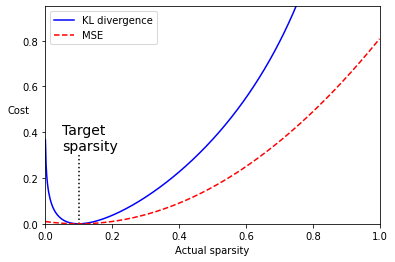

In [31]:
#ref : https://github.com/ageron/handson-ml
## Sparsity Loss 
pp = 0.1
qq = np.linspace(0.001, 0.999, 500)
# p * np.log(p / q): left slop 
# (1 - p) * np.log((1 - p) / (1 - q)) : right slop 
kl_div = pp * np.log(pp / qq) + (1 - pp) * np.log((1 - pp) / (1 - qq))

mse = (pp - qq)**2
plt.plot([pp, pp], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(qq, kl_div, "b-", label="KL divergence")
plt.plot(qq, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

### Single AutoEncoder Layer

In [32]:
class Encoder(keras.layers.Layer):
    def __init__(self, h_units=10, name='encoder', sparsity_weight=1e-2, sparsity_target=0.5, l2_reg=1e-3): 
        super().__init__(name=name)
        self.dense = keras.layers.Dense(units=h_units, activation='sigmoid',
                            kernel_regularizer=keras.regularizers.l2(l=l2_reg))
        self.sparsity_target = sparsity_target 
        self.sparsity_weight = sparsity_weight

    def call(self, inputs):
        h = self.dense(inputs)
        self.add_loss(self.sparsity_loss(h))
        return h

    def sparsity_loss(self, h):
        mean_activation = tf.reduce_mean(h, axis=0)
        kl_loss = (keras.losses.KLD(self.sparsity_target, mean_activation) +
                  keras.losses.KLD(1 - self.sparsity_target, 1 - mean_activation))
        return self.sparsity_weight * kl_loss

In [33]:
class Decoder(keras.layers.Layer):
    def __init__(self, original_dim, name='decoder', l2_reg=1e-3):
        super().__init__(name=name)
        self.outputs = keras.layers.Dense(units=original_dim, activation='sigmoid',
                              kernel_regularizer=keras.regularizers.l2(l=l2_reg))
    def call(self, inputs):
        x = self.outputs(inputs)
        return x

In [34]:
class AutoEncoder(keras.Model):
    def __init__(self, original_dim, h_units, l2_reg=1e-3, sparsity_weight=1e-2, sparsity_target=0.5):
        super().__init__()
        self.encoder = Encoder(h_units=h_units,
                               sparsity_weight=sparsity_weight,
                               sparsity_target=sparsity_target,
                               l2_reg=l2_reg)
        self.decoder = Decoder(original_dim=original_dim,
                               l2_reg=l2_reg)
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

### Stacked AutoEncoer

In [35]:
class StackedAutoEncoder():
    def __init__(self, layers, original_dim, h_units, l2_reg=1e-3, sparsity_weight=1e-2, sparsity_target=0.5):
        # 1st AE
        self.ae = [AutoEncoder(original_dim, h_units, l2_reg, sparsity_weight, sparsity_target)]
        # Stacking AE
        for k in range(layers - 1): 
            self.ae.append(AutoEncoder(h_units, h_units, l2_reg, sparsity_weight, sparsity_target))
            
    def train_one_ae(self, model, inputs, learning_rate=0.01, n_epochs=20, batch_size=128 ):
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        num_train = inputs.shape[0]
        n_batches = int(num_train / batch_size)

        loss_lst = []
        for epoch in range(n_epochs):
            total_loss = 0
            for i in range(n_batches):
                sample_idxs = np.random.choice(num_train, batch_size)#(128,) 
                x_batch = inputs[sample_idxs, :]                     #(128,6)
                with tf.GradientTape() as tape:
                    x_rec = model(x_batch)                           #single AE
                    regularization_loss = tf.add_n(model.losses)
                    loss = 0.5 * tf.reduce_sum(tf.square(x_rec - x_batch)) + regularization_loss
                grads = tape.gradient(loss, model.variables)
                optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
                loss_lst.append(loss.numpy())
                total_loss += loss.numpy()
            print(f'Total loss[{epoch}] : {total_loss}')

    def train_stacked_ae(self, inputs, learning_rate=0.01, n_epochs=20, batch_size=128):
        print(f'AE_1') 
        self.train_one_ae(self.ae[0], inputs, learning_rate, n_epochs, batch_size)
        h = inputs 
        for i in range(1, len(self.ae)):
            h = self.ae[i - 1].encoder(h).numpy()#이전 AE의 Encoder만 사용
            print(f'AE_{i+1}')
            self.train_one_ae(self.ae[i], h, learning_rate, n_epochs, batch_size)
            
    def encode(self, x_input):
        h = x_input
        for ae in self.ae:
            h = ae.encoder(h).numpy()
        return h                    

### Training Data 

In [36]:
## SAE input data 확인 
pst(w_x_train),pst(w_x_test)

[] Shape(4890, 6), <class 'numpy.ndarray'>
[] Shape(544, 6), <class 'numpy.ndarray'>


(None, None)

### SAE model Instantiation

In [37]:
## SAE = StackedAutoEncoder(layers=5, original_dim=18, h_units=10)
layers= 3
original_dim = w_x_train.shape[1] # 6
h_units = 3

SAE = StackedAutoEncoder(layers=layers, original_dim=original_dim, h_units=h_units)

### SAE Training

In [38]:
SAE.train_stacked_ae(w_x_train, learning_rate=0.01, n_epochs=50, batch_size=128) # n_epochs=50

AE_1
Total loss[0] : 1105.6257276535034
Total loss[1] : 416.45769119262695
Total loss[2] : 253.77262592315674
Total loss[3] : 198.2180666923523
Total loss[4] : 168.00145506858826
Total loss[5] : 132.7949321269989
Total loss[6] : 106.54282093048096
Total loss[7] : 82.31932854652405
Total loss[8] : 66.9113552570343
Total loss[9] : 56.269619822502136
Total loss[10] : 48.35092616081238
Total loss[11] : 40.732097864151
Total loss[12] : 34.52235198020935
Total loss[13] : 29.74996840953827
Total loss[14] : 26.342022866010666
Total loss[15] : 24.11375194787979
Total loss[16] : 21.61614739894867
Total loss[17] : 19.24110385775566
Total loss[18] : 18.71501913666725
Total loss[19] : 17.849960178136826
Total loss[20] : 17.549261301755905
Total loss[21] : 17.507718324661255
Total loss[22] : 16.01087462902069
Total loss[23] : 16.52541959285736
Total loss[24] : 16.18345594406128
Total loss[25] : 14.932217746973038
Total loss[26] : 15.454165130853653
Total loss[27] : 16.05915129184723
Total loss[28] :

### SAE 학습결과를 w_x_train, w_x_test에 적용 

In [39]:
## 학습된 SAE에 train data적용 
sae_x_train = SAE.encode(w_x_train)

## 학습된 SAE에 test data 적용 
sae_x_test = SAE.encode(w_x_test)

ps(sae_x_train),ps(sae_x_test)

[] Shape(4890, 3)
[] Shape(544, 3)


(None, None)

**SAE 입력과 출력 비교**

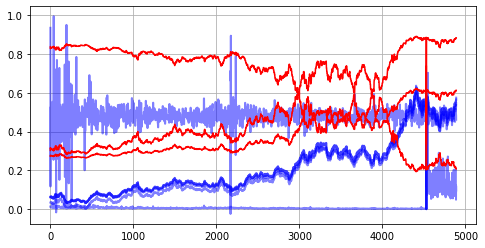

In [40]:
## SAE input데이터와 output(LSTM입력) 비교 
s_p = 0
e_p = -1
plot_diff(w_x_train[:,:],sae_x_train[:,:],s_p,e_p) # Train_Close

## LSTM 

### Import Module

In [41]:
# import numpy as np
# import tensorflow as tf
# import tensorflow.keras as keras
# import tensorflow_probability as tfp


#from .metrics import MeanAbsolutePercentageError, TheilU, LinearCorrelation
#https://github.com/ivan-ivy/ECBM4040-final-project-WSAE-LSTM 

### LSTM model define

In [42]:
#def build_lstm_model(inputs_shape, layers=5, units=64, learning_rate=0.05):
def build_lstm_model(inputs_shape, layers=3, units=16, learning_rate=0.001):

    model = keras.Sequential()
    # ad layers using loop
    model.add(keras.layers.Input(shape=inputs_shape))
    model.add(keras.layers.LSTM(units=units, return_sequences=True))
    for i in range(1, layers-1):
        model.add(keras.layers.LSTM(units=units, return_sequences=True))
    model.add(keras.layers.LSTM(units=units))
    model.add(keras.layers.Dense(1))

    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[keras.metrics.MeanAbsolutePercentageError(),
# LinearCorrelation() --> tfp.stats.correlation( )
# Theil_U()
                      ]
                  )
    return model

### Prepare Sequence dataset for training 

In [43]:
# x_l = x_train    
# x_l = w_x_train  #
l_x_train = sae_x_train  # SAE 통과한 x_train
l_y_train = y_train      # target data

l_x_test = sae_x_test    # for validation
l_y_test = y_test 

In [44]:
len(l_x_train),len(l_y_train),len(l_x_test),len(l_y_test)

(4890, 4890, 544, 544)

In [45]:
# sequence generator
## x:4일치 데이터, y:5일차 종가
timesteps = seq_length = 4
def sequence_gen(data,length):
    seqX = []
    for i in range(0, len(data)-length+1):
        _x = data[i:i + length] # Sequence(timesetp,feature) 
        seqX.append(_x)
    return seqX
        
seq_x_train = np.array(sequence_gen(l_x_train,timesteps))
seq_y_train = y_train[timesteps-1:]

seq_x_test = np.array(sequence_gen(l_x_test,timesteps))
seq_y_test = y_test[timesteps-1:]

In [46]:
pst(seq_x_train),pst(seq_y_train),pst(seq_x_test),pst(seq_y_test)

[] Shape(4887, 4, 3), <class 'numpy.ndarray'>
[] Shape(4887,), <class 'numpy.ndarray'>
[] Shape(541, 4, 3), <class 'numpy.ndarray'>
[] Shape(541,), <class 'numpy.ndarray'>


(None, None, None, None)

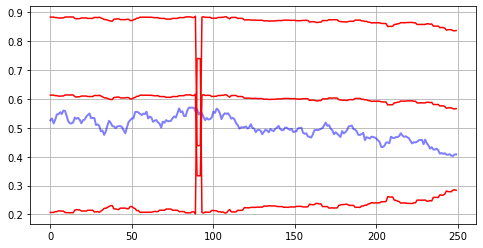

In [47]:
## Sequnce input과 target 확인
s_p = -450
e_p = -200
plot_diff(seq_y_train,seq_x_train[:,0,:],s_p,e_p) # Close
#plot_diff(X[:,4],w_data_x[:,4],s_p,e_p) # Chage

### Model Build

In [48]:
LSTM = build_lstm_model(inputs_shape=(seq_x_train.shape[1],seq_x_train.shape[2]))
LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 16)             1280      
                                                                 
 lstm_1 (LSTM)               (None, 4, 16)             2112      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,521
Trainable params: 5,521
Non-trainable params: 0
_________________________________________________________________


### LSTM Training

In [49]:
%%time
# model traing
history = LSTM.fit(seq_x_train, seq_y_train, 
                      validation_data=(seq_x_test, seq_y_test),
                      epochs = 50, batch_size = 64)

Epoch 1/50
77/77 [==============================] - 7s 26ms/step - loss: 0.0150 - mean_absolute_percentage_error: 10160.8525 - val_loss: 0.0567 - val_mean_absolute_percentage_error: 24.4451
Epoch 2/50
77/77 [==============================] - 1s 10ms/step - loss: 7.3638e-04 - mean_absolute_percentage_error: 8359.8311 - val_loss: 0.0688 - val_mean_absolute_percentage_error: 28.3975
Epoch 3/50
77/77 [==============================] - 1s 9ms/step - loss: 6.5517e-04 - mean_absolute_percentage_error: 9155.2188 - val_loss: 0.0600 - val_mean_absolute_percentage_error: 25.6908
Epoch 4/50
77/77 [==============================] - 1s 10ms/step - loss: 6.2980e-04 - mean_absolute_percentage_error: 9890.3037 - val_loss: 0.0596 - val_mean_absolute_percentage_error: 25.6056
Epoch 5/50
77/77 [==============================] - 1s 10ms/step - loss: 6.1675e-04 - mean_absolute_percentage_error: 10054.2988 - val_loss: 0.0608 - val_mean_absolute_percentage_error: 26.0691
Epoch 6/50
77/77 [====================

#### Metic Plot

In [50]:
history.history.keys()   # check logs.key

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

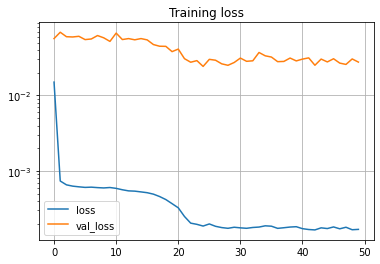

In [51]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.title("Training loss")
plt.semilogy()  # y축에 log scale적용
plt.grid(True)
plt.legend(loc='best')
plt.show()  

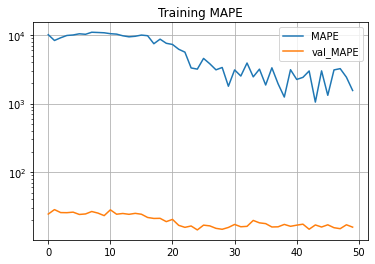

In [52]:
plt.plot(history.history['mean_absolute_percentage_error'], label='MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='val_MAPE')

plt.title("Training MAPE")
plt.semilogy()  # y축에 log scale적용
plt.grid(True)
plt.legend(loc='best')
plt.show()  

### Predict the stock price

In [53]:
s_p = 0
e_p = 200
X = seq_x_test[s_p:e_p]
Y = seq_y_test[s_p:e_p]
predicted_stock_price = LSTM.predict(X)

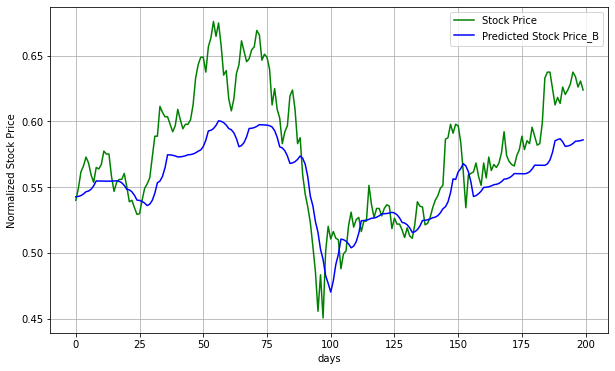

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(Y, color = 'green', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'blue',label = 'Predicted Stock Price_B')
# 
plt.xlabel('days')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.grid(True)
plt.show()

![image.png](attachment:3cb0e963-371d-43b3-941a-502229ca06b8.png) 